## Сезонная декомпозиция

Инсталируем версии statsmodels==0.11.1 


In [1]:
!pip install statsmodels==0.11.1

     |████████████████████████████████| 8.7 MB 5.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Импорт модулей для работы

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


from statsmodels.tsa.seasonal import STL

from statsmodels.datasets import elec_equip as ds



1. Читаем с локального диска данные

In [4]:
from google.colab import files
uploaded = files.upload()

Saving my_PJME_MW.csv to my_PJME_MW.csv


Читаем данные в память - причесываем немного и берем для работы 1-й столбец (остальные можно было бы убрать)

In [37]:

Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [38]:
data = data.iloc[:,:1]
data.head()

,PJME_MW
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


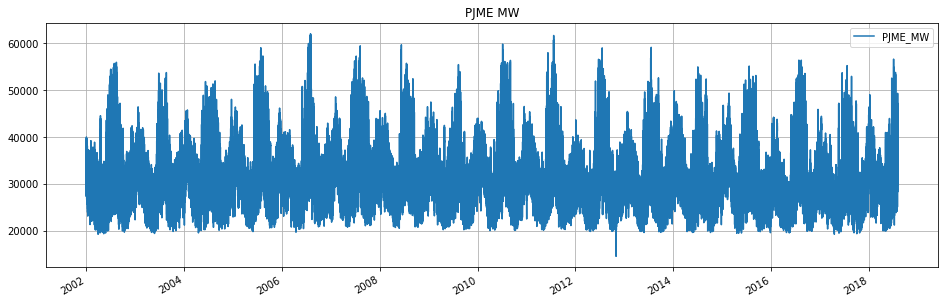

In [39]:

data.plot(figsize = (16,5))
plt.grid(True)
plt.title('PJME MW')
plt.show()

In [23]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

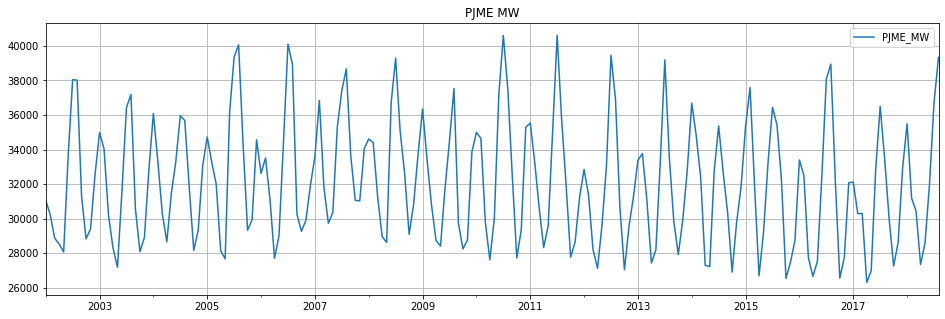

In [42]:
data_m.plot(figsize = (16,5))
plt.grid(True)
plt.title('PJME MW')
plt.show()

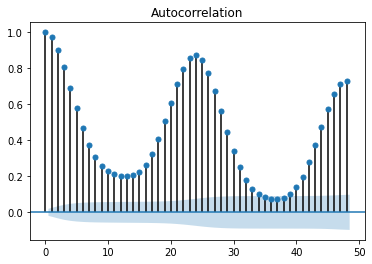

In [44]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()


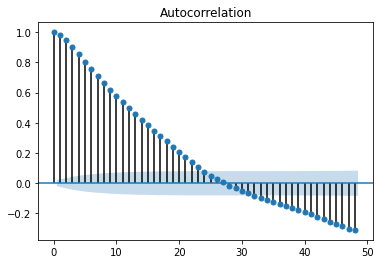

In [21]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].diff(24).values[100:10000], lags=24*2)
plt.show()

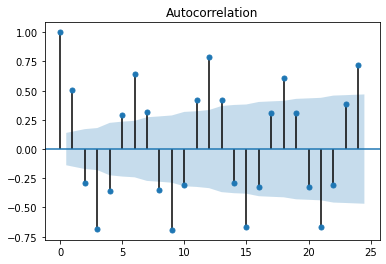

In [45]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values[:10000], lags=12*2)
plt.show()

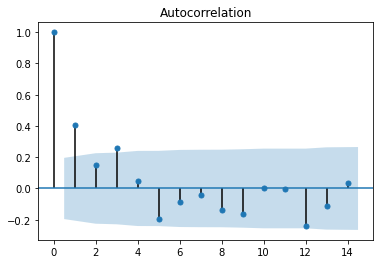

In [46]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].diff(12).values[100:10000], lags=14)
plt.show()

Создаем модель для анализа сезонности по (Seasonal
Transformation using LOESS — «STL»  https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html , LOESS- метод локальных полиномиальных регрессий  (Методы социально-экономического прогнозирования в 2т. т.2 - Светуньков) и https://www.machinelearningmastery.ru/decompose-time-series-data-trend-seasonality/)
- вычисление тренда
- подбор сглаживания
- оценка остатков



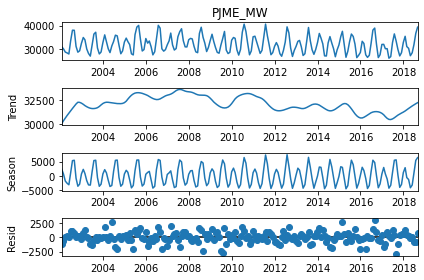

In [51]:
stl = STL(data_m['PJME_MW'], period=12)
res = stl.fit()
fig = res.plot()

Получили тренд и сезон, посмотрим

In [52]:
Trend = res.trend
Season = res.seasonal


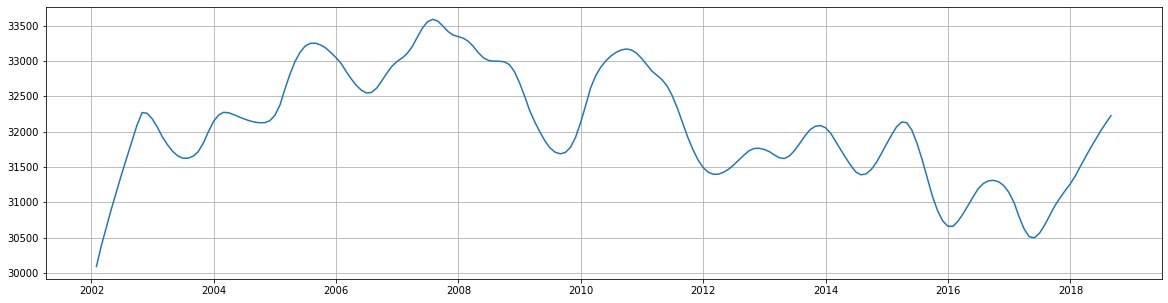

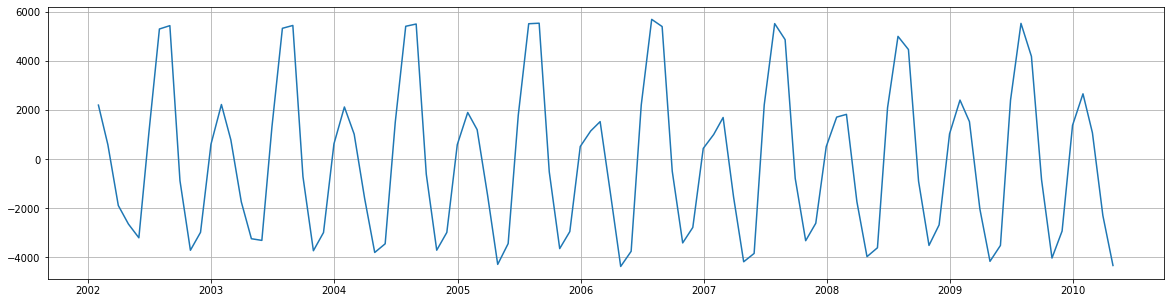

In [53]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(Trend[:500])
plt.show()
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(Season[:100])
plt.show()

Оценим остатки:

In [54]:

from statsmodels.tsa.stattools import adfuller
print('не стационарный с вероятностью : ',adfuller(res.resid[:200], regression='ctt')[1])

не стационарный с вероятностью :  3.466803403482279e-10


Построим простую модель для дневных циклов:

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
# Соберем примеров для модели с глубиной р
data_dd = pd.DataFrame(data=Season[12:], index=data_m.index[12:])
p = 12
for i in range(p):
    data_dd['d'+str(p-i)]=0
    data_dd['d'+str(p-i)].values[p:] = data_dd['season'].values[i:-(p)+i]

In [60]:
data_dd.drop(data_dd.index[:p],axis=0,inplace=True)
data_dd.head()

,season,d12,d11,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
2004-01-31,2132.714895,2232,791,-1733,-3236,-3304,1324,5339,5454,-704,-3726,-2984,630
2004-02-29,1025.524034,791,-1733,-3236,-3304,1324,5339,5454,-704,-3726,-2984,630,2132
2004-03-31,-1589.294259,-1733,-3236,-3304,1324,5339,5454,-704,-3726,-2984,630,2132,1025
2004-04-30,-3796.943079,-3236,-3304,1324,5339,5454,-704,-3726,-2984,630,2132,1025,-1589
2004-05-31,-3443.253462,-3304,1324,5339,5454,-704,-3726,-2984,630,2132,1025,-1589,-3796


In [61]:
data_dd.shape

(176, 13)

In [62]:
h=1  # горизонт прогноза
y = data_dd.iloc[h:,:1].values
x = data_dd.iloc[:-h,:].values
# разберем выборку на тесты и тренировочный набор
N_split = 100

X_train = x[:-N_split,:]
y_train = y[:-N_split,:]

X_test = x[-N_split:,:]
y_test = y[-N_split:,:]
# строим модель
model_g = GradientBoostingRegressor(n_estimators=100)
model_g.fit(X_train,y_train)

y_pred = model_g.predict(X_test)

Оценим модель:

ошибка MAE = 3715.374875984654


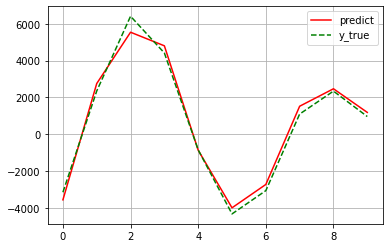

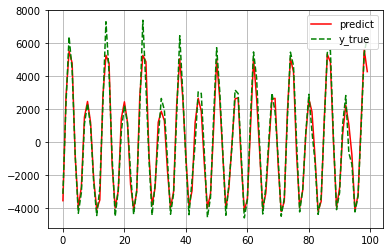

In [63]:
print('ошибка MAE =',np.mean(np.abs(y_pred-y_test)))

plt.plot(y_pred[:10],'r',label='predict')
plt.plot(y_test[:10],'--g',label='y_true')
plt.legend()
plt.grid()
plt.show()
plt.plot(y_pred[-100:],'r',label='predict')
plt.plot(y_test[-100:],'--g',label='y_true')
plt.legend()
plt.grid()
plt.show()

Результат работы можно еще раз обработать с другим лагом (недельные циклы)

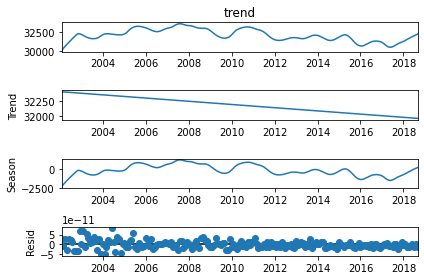

In [64]:
stlt = STL(Trend, period=7*24)
resw = stlt.fit()
fig = resw.plot()

Разница между моделями мультипликативного и аддитивного типа (https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose):

# - аддитивная у = тренд+сезон+остатки

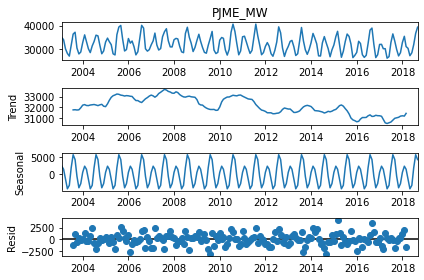

In [65]:
decomposition = sm.tsa.seasonal_decompose(data_m['PJME_MW'].iloc[12:200],  model='addinive', freq=12)
fig = decomposition.plot()
plt.show()

### Мельтипликативная у = тренд * сезон * остатки

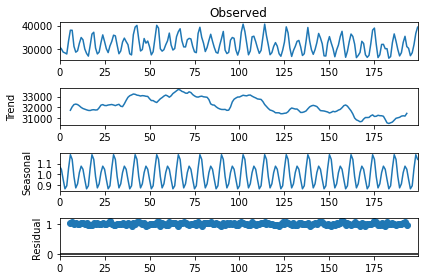

In [66]:
mean_s = sm.tsa.seasonal_decompose(data_m['PJME_MW'].values[:1000],  model='multiplicative', freq=12)
fig = mean_s.plot()
plt.show()
